In [ ]:

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from shapely.ops import voronoi_diagram, unary_union
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn_extra.cluster import KMedoids

import numpy as np

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

# Try to import KMedoids
try:
    from sklearn_extra.cluster import KMedoids
    KMEDOIDS_AVAILABLE = True
except ImportError:
    print("⚠️ sklearn-extra not available. KMedoids clustering will be skipped.")
    print("Install with: pip install scikit-learn-extra")
    KMEDOIDS_AVAILABLE = False

In [2]:
def load_dataset(path, name):
    """Load the dataset with comprehensive error handling"""
    path_ext = Path(path).suffix
    print(path_ext)
    try:
        if path_ext == '.gpkg':
            gdf = gpd.read_file(path)
            print(f"{name} data is loaded successfully! : {len(gdf)} features")
            print(f"{name} columns: {gdf.columns.tolist()}")
            print(f"{name} geometry types: {gdf.geometry.geom_type.value_counts().to_dict()}")
            return gdf
        elif path_ext == '.csv':
            csv = pd.read_csv(path)
            print(f"{name} data is loaded successfully! : {len(csv)} features")
            return csv
        else:
            print("Wrong File!")
    except Exception as e:
        print(f" ERROR Handling {name} data: {e}")
        return None

In [3]:
# Loading the Dataset to exploration
boundary = gdf_boundary = load_dataset("./DATAV2/Santa Barbara - Barangay Boundary.gpkg", "Boundary")
flooding = load_dataset("./DATAV2/Risks/Santa Barbara - Flooding.gpkg", "Flooding")
landslide = load_dataset("./DATAV2/Risks/Santa Barbara - Landslide.gpkg", "Landslide")
faults = load_dataset("./DATAV2/Risks/Santa Barbara - Nearest Fault.gpkg", "Faults")
population = load_dataset("./DATAV2/Risks/Santa Barbara - Vulnerability Data.csv", "Population")

# boundary_names = set(gdf_boundary["ADM4_EN"].str.strip())
# population_names = set(population["ADM4_EN"].str.strip())

# # Barangays in boundary but not in population
# missing_in_population = boundary_names - population_names
# # Barangays in population but not in boundary
# missing_in_boundary = population_names - boundary_names

# print("Missing in population:", missing_in_population)
# print("Missing in boundary:", missing_in_boundary)

risk_layers = {
    "Flooding" : flooding,
    "Landslide" : landslide,
    "Earthquake" : faults
}

target_crs = gdf_boundary.crs or 'EPSG:4326'
if gdf_boundary.crs is None:
    gdf_boundary.set_crs('EPSG:4326', inplace=True)
    target_crs = 'EPSG:4326'

.gpkg
Boundary data is loaded successfully! : 60 features
Boundary columns: ['ADM4_EN', 'ADM4_PCODE', 'ADM4_REF', 'ADM3_EN', 'ADM3_PCODE', 'ADM2_EN', 'ADM2_PCODE', 'ADM1_EN', 'ADM1_PCODE', 'ADM0_EN', 'ADM0_PCODE', 'date', 'validOn', 'validTo', 'Shape_Leng', 'Shape_Area', 'AREA_SQKM', 'layer', 'path', 'geometry']
Boundary geometry types: {'Polygon': 60}
.gpkg
Flooding data is loaded successfully! : 3 features
Flooding columns: ['id', 'Var', 'Muncode', 'geometry']
Flooding geometry types: {'MultiPolygon': 3}
.gpkg
Landslide data is loaded successfully! : 2505 features
Landslide columns: ['DN', 'geometry']
Landslide geometry types: {'Polygon': 2505}
.gpkg
Faults data is loaded successfully! : 4 features
Faults columns: ['average_dip', 'catalog_id', 'catalog_name', 'dip_dir', 'name', 'net_slip_rate', 'slip_type', 'downthrown_side_dir', 'average_rake', 'lower_seis_depth', 'upper_seis_depth', 'downthrown_side_id', 'reference', 'epistemic_quality', 'accuracy', 'activity_confidence', 'fs_name'

In [4]:
def check_consistent_crs(datasets, target_crs='EPSG:4326'):
    """Ensure all datasets have consistent CRS"""
    reprojected = {}
    
    for name, gdf in datasets.items():
        if gdf is not None:
            # Set CRS if missing
            if gdf.crs is None:
                print(f"Setting {name} CRS to {target_crs}")
                gdf.set_crs(target_crs, inplace=True)
            
            # Assign if no crs found (still need to refactor this.)
            if gdf.crs != target_crs:
                print(f"Reprojecting {name} from {gdf.crs} to {target_crs}")
                reprojected[name] = gdf.to_crs(target_crs)
            else:
                reprojected[name] = gdf.copy()
        else:
            reprojected[name] = None
    
    return reprojected


In [5]:
# Clip to avoid going outside of the Santa Barbara Boundary
def clip_to_boundary(gdf, boundary):
    return gpd.overlay(gdf, boundary, how='intersection')

def get_centroids(gdf):
    return gdf.geometry.centroid

In [6]:
# Clip risk layers to boundary
flooding_clipped = clip_to_boundary(flooding, boundary)
landslide_clipped = clip_to_boundary(landslide, boundary)
faults_clipped = clip_to_boundary(faults, boundary)

flooding_points = get_centroids(flooding_clipped)
landslide_points = get_centroids(landslide_clipped)
fault_points = get_centroids(faults_clipped)


In [7]:

# Creating the population vulnerability index to add to specific points
population["VIndex"] = population["Children"] + population["Elderly"] + population["PWD"] - population["Medical Access"]

population["wV"] = (population["VIndex"] - population["VIndex"].min()) / (population["VIndex"].max() - population["VIndex"].min())


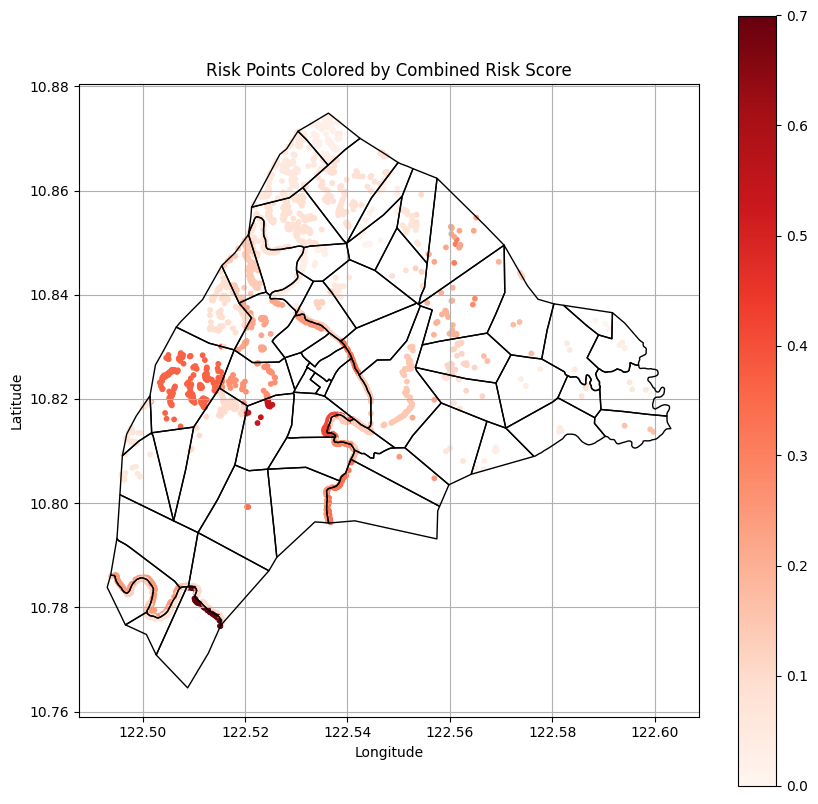

In [8]:
# Implementing a selectable system for different risks types (For future streamlit app)
selectable_keys = ["Flooding", "Landslide", "Earthquake"]

disaster_weights = {
    "Flooding": 1.0,
    "Landslide": 0.7,
    "Earthquake": 0.5
}

# For this example, only use Flooding and Landslide
selectable_keys = ["Flooding", "Landslide"]

selected_points = []
point_weights = []
for key in selectable_keys:
    layer = risk_layers[key]
    clipped = gpd.overlay(layer, boundary, how="intersection")
    centroids = clipped.geometry.centroid
    selected_points.extend(centroids)
    point_weights.extend([disaster_weights[key]] * len(centroids))

# Create GeoDataFrame for risk points
risk_gdf = gpd.GeoDataFrame({'geometry': selected_points, 'weight': point_weights}, crs=boundary.crs)

# Always spatially join to get ADM4_EN for each point
risk_gdf = gpd.sjoin(risk_gdf, boundary[['ADM4_EN', 'geometry']], how='left', predicate='within')

# Merge the vulnerability index from the population dataframe
risk_gdf = risk_gdf.merge(population[['ADM4_EN', 'wV']], on='ADM4_EN', how='left')

# Compute risk_score as weighted vulnerability
risk_gdf['risk_score'] = risk_gdf['wV'] * risk_gdf['weight']

# If you want to apply the Vulnerability Index as a multiplier only for specific risk gd:
selected_key = ""  # Empty means it includes all of the risks.

if selected_key:
    # If a specific risk is selected, adjust risk_score accordingly
    if selected_key == "Flooding":
        n_flood = len(get_centroids(clip_to_boundary(risk_layers["Flooding"], boundary)))
        risk_gdf.loc[:n_flood-1, 'risk_score'] = risk_gdf.loc[:n_flood-1, 'wV'] * disaster_weights['Flooding']
    elif selected_key == "Landslide":
        n_landslide = len(get_centroids(clip_to_boundary(risk_layers["Landslide"], boundary)))
        risk_gdf.loc[:n_landslide-1, 'risk_score'] = risk_gdf.loc[:n_landslide-1, 'wV'] * disaster_weights['Landslide']
    elif selected_key == "Earthquake":
        n_faults = len(get_centroids(clip_to_boundary(risk_layers["Earthquake"], boundary)))
        risk_gdf.loc[:n_faults-1, 'risk_score'] = risk_gdf.loc[:n_faults-1, 'wV'] * disaster_weights['Earthquake']
    else:
        risk_gdf['risk_score'] = risk_gdf['wV']
    print(risk_gdf['risk_score'].describe())

# Visualize risk points colored by risk_score
fig, ax = plt.subplots(figsize=(10, 10))
boundary.boundary.plot(ax=ax, color='black', linewidth=1)
risk_gdf.plot(ax=ax, column='risk_score', cmap='Reds', markersize=10, legend=True)
plt.title("Risk Points Colored by Combined Risk Score")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [9]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def evaluate_clustering(X, labels, algo_name):
    if len(set(labels)) <= 1 or -1 in set(labels):      
        print(f"{algo_name}: Not valid clustering (1 or no clusters)")
        return None
    sil_score = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    print(f"{algo_name} - Silhouette Score: {sil_score:.3f}, Calinski-Harabasz Index: {ch_score:.1f}")
    return sil_score, ch_score


In [14]:
n_responders = 10  # Change this for responders

# Build coords array with vulnerability index
coords = np.array([[geom.x, geom.y, risk_gdf.iloc[i]['wV']] for i, geom in enumerate(risk_gdf.geometry)])

# Remove rows with NaN in coords and update risk_gdf accordingly
mask = ~np.isnan(coords).any(axis=1)
coords_clean = coords[mask]
risk_gdf_clean = risk_gdf.iloc[mask].reset_index(drop=True)

kmeans = KMeans(n_clusters=n_responders, random_state=42)
labels_kmeans = kmeans.fit_predict(coords_clean)
print(labels_kmeans)

# KMedoids
kmedoids = KMedoids(n_clusters=n_responders, random_state=42)
labels_kmedoids = kmedoids.fit_predict(coords_clean)

# Agglomerative
agglo = AgglomerativeClustering(n_clusters=n_responders)
labels_agglo = agglo.fit_predict(coords_clean)

# DBSCAN (doesn't require n_clusters)
dbscan = DBSCAN(eps=0.5, min_samples=3)
labels_dbscan = dbscan.fit_predict(coords_clean)

results = {}
results['KMeans'] = evaluate_clustering(coords_clean, labels_kmeans, "KMeans")
results['KMedoids'] = evaluate_clustering(coords_clean, labels_kmedoids, "KMedoids")
results['Agglomerative'] = evaluate_clustering(coords_clean, labels_agglo, "Agglomerative")
results['DBSCAN'] = evaluate_clustering(coords_clean, labels_dbscan, "DBSCAN")


[0 0 0 ... 2 2 2]
KMeans - Silhouette Score: 0.534, Calinski-Harabasz Index: 11351.9
KMedoids - Silhouette Score: 0.481, Calinski-Harabasz Index: 2086.6
Agglomerative - Silhouette Score: 0.561, Calinski-Harabasz Index: 12690.3
DBSCAN: Not valid clustering (1 or no clusters)


In [15]:
best_algo = max((algo for algo in results.items() if algo[1] is not None), key=lambda x: x[1][0])
print(f"Best clustering method: {best_algo[0]}")

# Assign labels to GeoDataFrame (use risk_gdf_clean, which matches the label array length)
if best_algo[0] == 'KMeans':
    risk_gdf_clean['cluster'] = labels_kmeans
elif best_algo[0] == 'KMedoids':
    risk_gdf_clean['cluster'] = labels_kmedoids
elif best_algo[0] == 'Agglomerative':
    risk_gdf_clean['cluster'] = labels_agglo
elif best_algo[0] == 'DBSCAN':
    risk_gdf_clean['cluster'] = labels_dbscan

Best clustering method: Agglomerative


[<POINT Z (122.54 10.854 0.039)>, <POINT Z (122.531 10.827 0.358)>, <POINT Z (122.512 10.78 1)>, <POINT Z (122.541 10.827 0.199)>, <POINT Z (122.521 10.818 0.52)>, <POINT Z (122.524 10.818 0.77)>, <POINT Z (122.529 10.851 0.123)>, <POINT Z (122.501 10.783 0.35)>, <POINT Z (122.534 10.86 0.081)>, <POINT Z (122.507 10.796 0.13)>]


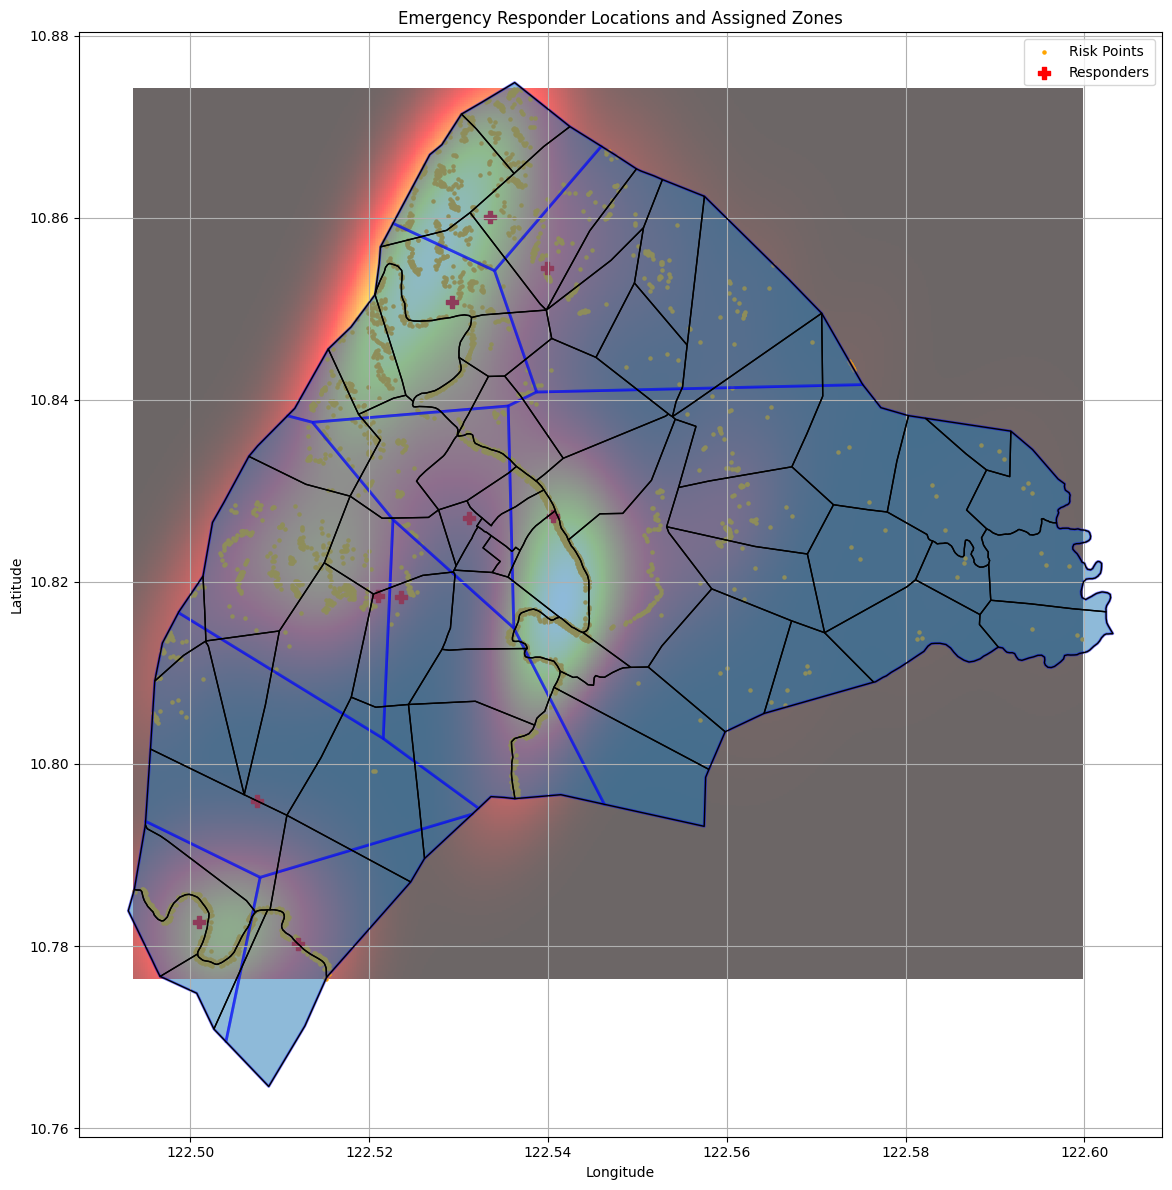

In [18]:
# Responder Locations
centroids = [Point(xy) for xy in kmeans.cluster_centers_]
centroid_gdf = gpd.GeoDataFrame(geometry=centroids, crs=boundary.crs)

print(centroids)

# Range of Responder Placements
voronoi = voronoi_diagram(unary_union(centroid_gdf.geometry), envelope=boundary.unary_union)
voronoi_clipped = [poly.intersection(boundary.unary_union) for poly in voronoi.geoms]
voronoi_gdf = gpd.GeoDataFrame(geometry=voronoi_clipped, crs=boundary.crs)

# Prepare data for heatmap
x = coords[:, 0]
y = coords[:, 1]

# Heatmapping
kde = gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]
zi = kde(np.vstack([xi.flatten(), yi.flatten()]))

fig, ax = plt.subplots(figsize=(12, 12))
boundary.boundary.plot(ax=ax, color='black', linewidth=1)
ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='hot', shading='auto', alpha=0.6)
risk_gdf.plot(ax=ax, color='orange', markersize=5, label="Risk Points")
centroid_gdf.plot(ax=ax, color='red', marker='P', markersize=80, label="Responders")
voronoi_gdf.plot(ax=ax, edgecolor='blue', alpha=0.5, linewidth=2, label="Voronoi Regions")
plt.legend()
plt.title("Emergency Responder Locations and Assigned Zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

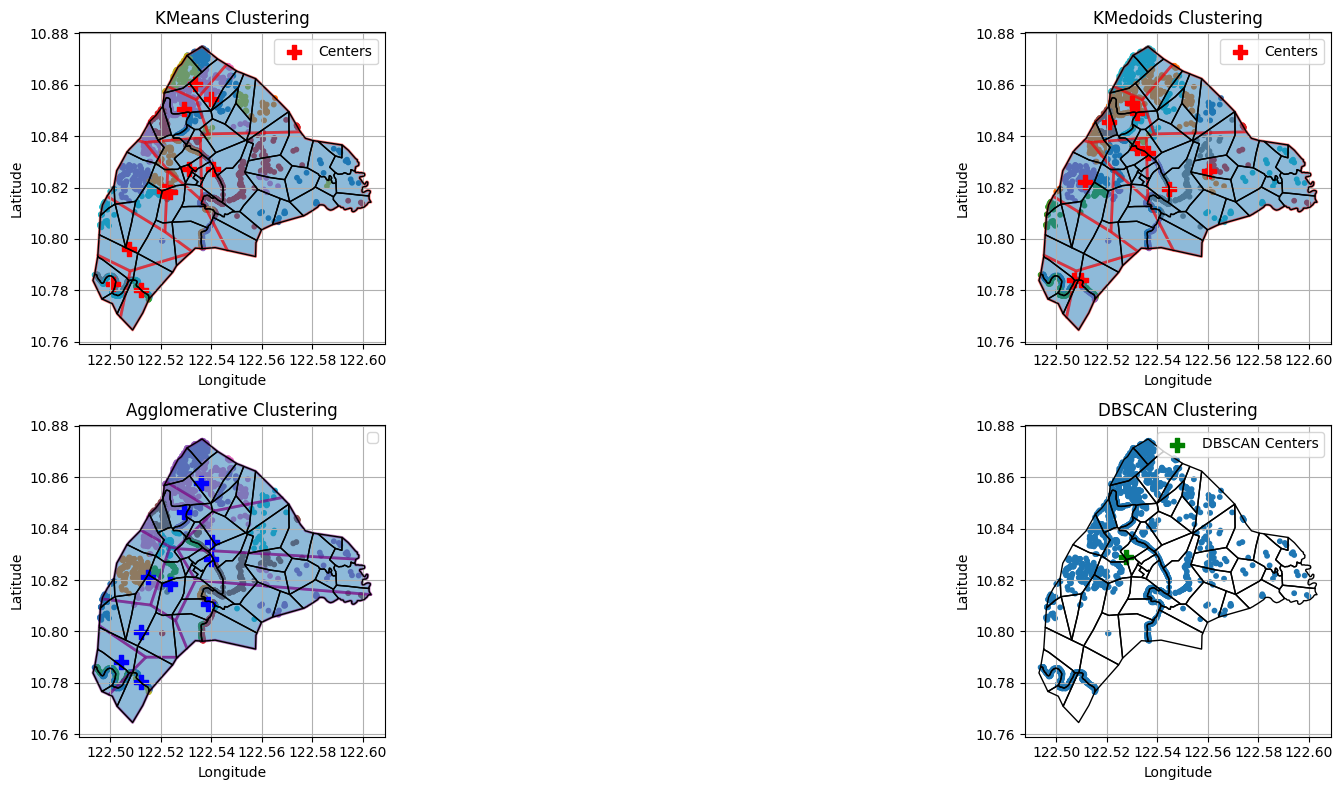

In [17]:
from shapely.geometry import Point
from shapely.ops import voronoi_diagram, unary_union

fig, axes = plt.subplots(2, 2, figsize=(24, 8))
axes = axes.flat

algos = [
    ('KMeans', labels_kmeans, kmeans.cluster_centers_),
    ('KMedoids', labels_kmedoids, kmedoids.cluster_centers_)
]

for ax, (algo_name, labels, centers) in zip(axes, algos):
    boundary.boundary.plot(ax=ax, color='black', linewidth=1)
    risk_gdf_clean.assign(cluster=labels).plot(ax=ax, column='cluster', cmap='tab10', markersize=10, legend=False)
    voronoi_gdf.plot(ax=ax, edgecolor='red', alpha=0.5, linewidth=2, label="Voronoi Regions")
    if centers is not None:
        ax.scatter(centers[:, 0], centers[:, 1], c='red', marker='P', s=100, label='Centers')
    ax.set_title(f"{algo_name} Clustering")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)
    ax.legend()

# Add Agglomerative as a fourth subplot
ax = axes[2]
boundary.boundary.plot(ax=ax, color='black', linewidth=1)
risk_gdf_clean.assign(cluster=labels_agglo).plot(ax=ax, column='cluster', cmap='tab10', markersize=10, legend=False)
# Compute Voronoi for Agglomerative centers and plot

agglo_centers = []
for i in range(n_responders):
    cluster_points = coords_clean[labels_agglo == i]
    if len(cluster_points) > 0:
        center = cluster_points.mean(axis=0)
        agglo_centers.append(center)
agglo_centers = np.array(agglo_centers)

agglo_points = [Point(center[0], center[1]) for center in agglo_centers]
if len(agglo_points) > 1:
    agglo_voronoi = voronoi_diagram(unary_union(agglo_points), envelope=boundary.unary_union)
    agglo_voronoi_clipped = [poly.intersection(boundary.unary_union) for poly in agglo_voronoi.geoms]
    agglo_voronoi_gdf = gpd.GeoDataFrame(geometry=agglo_voronoi_clipped, crs=boundary.crs)
    agglo_voronoi_gdf.plot(ax=ax, edgecolor='purple', alpha=0.5, linewidth=2, label="Agglo Voronoi")
ax.set_title("Agglomerative Clustering")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.legend()

# Plot Agglomerative responder positions
ax.scatter(agglo_centers[:, 0], agglo_centers[:, 1], c='blue', marker='P', s=100, label='Agglo Centers')

# Add DBSCAN as the fourth subplot
ax = axes[3]
boundary.boundary.plot(ax=ax, color='black', linewidth=1)
risk_gdf_clean.assign(cluster=labels_dbscan).plot(ax=ax, column='cluster', cmap='tab10', markersize=10, legend=False)

# DBSCAN does not have cluster centers
unique_labels = set(labels_dbscan)
unique_labels.discard(-1)
dbscan_centers = []
for lbl in unique_labels:
    cluster_points = coords_clean[labels_dbscan == lbl]
    if len(cluster_points) > 0:
        center = cluster_points.mean(axis=0)
        dbscan_centers.append(center)
dbscan_centers = np.array(dbscan_centers)
if len(dbscan_centers) > 0:
    ax.scatter(dbscan_centers[:, 0], dbscan_centers[:, 1], c='green', marker='P', s=100, label='DBSCAN Centers')

ax.set_title("DBSCAN Clustering")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()